### Data Visualization - Ideal vs Encountered

In [2]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py


#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance
import geopandas as gpd
import utm
import datetime as dt

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from IPython.display import HTML


#### Load Data

In [90]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set01/'
windbag = 'wind01Run03.hdf'
westeast_load = 'ewdata01Run03.hdf'
northsouth_load= 'nsdata01Run03.hdf'
odor_load = 'Interpolated_1.h5'

In [91]:
#windbag
wind=pd.read_hdf(dir+windbag)
we=pd.read_hdf(dir+westeast_load)
ns=pd.read_hdf(dir+northsouth_load)

In [92]:
#odorbag
odor= pd.read_hdf(dir+odor_load)
time= odor.master_time-odor.master_time[0]
odor.insert(1,'sync_time',time) 

In [93]:
#odor.master_time.iloc[0]

In [94]:
#odor.master_time.iloc[-1]

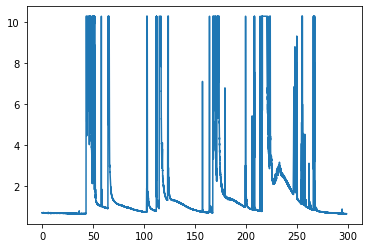

In [97]:
plt.plot(odor.sync_time, odor.odor)

In [102]:
odor

,master_time,sync_time,odor,trisonica_U,trisonica_V,lat,lon,geometry
0,1.603225e+09,0.000000,0.696277,0.990000,1.780000,40.793708,-119.157795,POINT (-119.15779 40.79371)
1,1.603225e+09,0.004997,0.696922,1.016159,1.810183,40.793708,-119.157795,POINT (-119.15779 40.79371)
2,1.603225e+09,0.009993,0.698000,1.042318,1.840366,40.793708,-119.157795,POINT (-119.15780 40.79371)
3,1.603225e+09,0.014990,0.696309,1.068476,1.870550,40.793708,-119.157795,POINT (-119.15780 40.79371)
4,1.603225e+09,0.019986,0.697053,1.094635,1.900733,40.793708,-119.157795,POINT (-119.15780 40.79371)
...,...,...,...,...,...,...,...,...
59773,1.603225e+09,298.658076,0.641831,1.498631,1.988529,40.793959,-119.157684,POINT (-119.15768 40.79396)
59774,1.603225e+09,298.663072,0.644237,1.484791,2.045867,40.793959,-119.157684,POINT (-119.15768 40.79396)
59775,1.603225e+09,298.668069,0.641464,1.470950,2.103206,40.793959,-119.157685,POINT (-119.15768 40.79396)
59776,1.603225e+09,298.673065,0.640290,1.457110,2.160544,40.793958,-119.157685,POINT (-119.15768 40.79396)


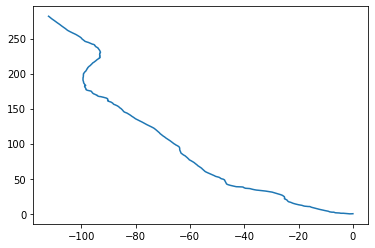

In [104]:
plt.plot(we.particle0, ns.particle0)

#### Converting lat lon information to meters

In [98]:
from shapely.geometry import Point
odor['geometry'] = odor.apply(lambda row: Point(row.lon, row.lat), axis=1)

geodf = gpd.GeoDataFrame(odor)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_def")

geodf["x"] = geodf.geometry.apply(lambda row:row.x)
geodf["y"] = geodf.geometry.apply(lambda row:row.y)

In [99]:
#source location to meters
source = (40.79376709443614, -119.15757512132207)
u =  utm.from_latlon(40.79376709443614, -119.15757512132207)

In [100]:
#adding sync_time from zero, optional

newtime= wind.sync_time-wind.sync_time.iloc[0]
wind.insert(1,'ntime',newtime) 

newtime=newtime.reset_index()
# newtime = newtime.drop(columns=['index'])

we.insert(0,'sync_time',newtime.sync_time)
ns.insert(0,'sync_time',newtime.sync_time)

In [101]:
xfromsrc= geodf.x-u[0]
geodf.insert(10,'xsrc',xfromsrc) 

yfromsrc = geodf.y-u[1]
geodf.insert(11,'ysrc', yfromsrc)

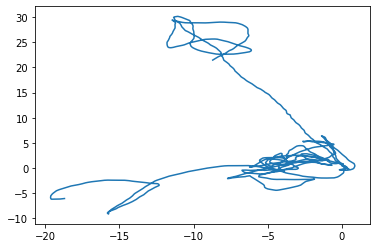

In [111]:
plt.plot(geodf.xsrc, geodf.ysrc)

#### Selecting a smaller slot of data

In [106]:
query = 'sync_time >= 40  and sync_time <=130'
dfo = odor.query(query)
dfwe = we.query(query)
dfns = ns.query(query)
dfwe = dfwe.reset_index()
dfns = dfns.reset_index()

In [107]:
query = 'odor >= 7'
df_t=geodf.query(query)
df_t=df_t.reset_index()

In [108]:
query_ = 'sync_time >= 40 and sync_time <=130'
geodfsub = geodf.query(query_)
geodfsub = geodfsub.reset_index()

In [109]:
geodfsub

,index,master_time,sync_time,odor,trisonica_U,trisonica_V,lat,lon,geometry,x,y,xsrc,ysrc
0,8006,1.603225e+09,40.002285,0.650813,0.534097,1.313049,40.793757,-119.157574,POINT (317973.886 4518102.257),317973.885559,4.518102e+06,0.048368,-1.139683
1,8007,1.603225e+09,40.007281,0.653223,0.580342,1.357284,40.793757,-119.157574,POINT (317973.887 4518102.261),317973.887341,4.518102e+06,0.050149,-1.135842
2,8008,1.603225e+09,40.012278,0.650109,0.626588,1.401519,40.793757,-119.157574,POINT (317973.889 4518102.264),317973.889123,4.518102e+06,0.051931,-1.132000
3,8009,1.603225e+09,40.017274,0.651282,0.672833,1.445753,40.793757,-119.157574,POINT (317973.891 4518102.268),317973.890905,4.518102e+06,0.053713,-1.128159
4,8010,1.603225e+09,40.022271,0.649828,0.719078,1.489988,40.793757,-119.157574,POINT (317973.893 4518102.272),317973.892687,4.518102e+06,0.055495,-1.124318
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18008,26014,1.603225e+09,129.979944,1.302216,1.035562,0.899271,40.793782,-119.157628,POINT (317969.376 4518105.107),317969.375798,4.518105e+06,-4.461394,1.710232
18009,26015,1.603225e+09,129.984940,1.293474,1.041618,0.909364,40.793781,-119.157628,POINT (317969.381 4518105.105),317969.380619,4.518105e+06,-4.456573,1.709003
18010,26016,1.603225e+09,129.989937,1.294909,1.047674,0.919456,40.793781,-119.157628,POINT (317969.385 4518105.104),317969.385439,4.518105e+06,-4.451753,1.707774
18011,26017,1.603225e+09,129.994933,1.298527,1.053730,0.929549,40.793781,-119.157628,POINT (317969.390 4518105.103),317969.390260,4.518105e+06,-4.446932,1.706546


In [110]:
dfwe

,index,sync_time,particle0,particle1,particle2,particle3,particle4,particle5,particle6,particle7,...,particle2976,particle2977,particle2978,particle2979,particle2980,particle2981,particle2982,particle2983,particle2984,particle2985
0,400,40.000092,-20.124684,-20.074183,-20.017181,-19.968180,-19.919179,-19.845677,-19.778675,-19.709673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,401,40.100095,-20.156685,-20.106184,-20.049182,-20.000181,-19.951180,-19.877678,-19.810676,-19.741674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,402,40.200097,-20.194186,-20.143685,-20.086683,-20.037682,-19.988681,-19.915179,-19.848177,-19.779175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,403,40.300100,-20.239687,-20.189186,-20.132185,-20.083183,-20.034182,-19.960680,-19.893678,-19.824676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,404,40.400103,-20.280189,-20.229687,-20.172686,-20.123684,-20.074683,-20.001181,-19.934179,-19.865177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,1296,129.599538,-61.321129,-61.270628,-61.213626,-61.164625,-61.115624,-61.042122,-60.975120,-60.906118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,1297,129.699540,-61.366130,-61.315629,-61.258628,-61.209626,-61.160625,-61.087123,-61.020121,-60.951119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
898,1298,129.799543,-61.422632,-61.372131,-61.315129,-61.266128,-61.217126,-61.143624,-61.076623,-61.007621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
899,1299,129.899546,-61.472133,-61.421632,-61.364631,-61.315629,-61.266628,-61.193126,-61.126124,-61.057122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
dfwe.sync_time[1]

150.10009741783142

In [ ]:
# drop additional time stamps if necessary
# dfns = dfns.drop(columns=[ 'index1', 'sync_time'])
# dfwe = dfwe.drop(columns=['index', 'sync_time'])

#### Alternative animation method using multiple plots (extremely slow)

In [29]:
dir = '../../../Research/Images/recurringplots/'
for i in range(300):
    fig.suptitle('Odor Encounters')
    fig = plt.figure()
    ax = plt.axes(xlim=(-25,2.5), ylim=(-16,3))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
  
    ax.scatter(geodfsub.xsrc[:i],geodfsub.ysrc[:i], c=geodfsub.odor[:i], cmap='magma', s=i*0.1)
    plt.scatter(dfwe.loc[i],dfns.loc[i],c ='b', cmap='magma', s=i*0.1)
    
    fig.savefig(dir + "plot" + str(i) + ".png")
    plt.close()

#### Animation 01 - Wind Only

In [7]:
fig = plt.figure()
ax = plt.axes(xlim=(-25,2.5), ylim=(-16,3))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()
line, = ax.plot([],[], 'o', lw=2)

def init():
    line.set_data([],[])
    return line,

def get_data_x(i):
    return we.loc[i]

def get_data_y(i):
    return ns.loc[i]

def update(i):
    x = get_data_x(i)
    y = get_data_y(i)
    line.set_data(x,y)
    return line,

an = animation.FuncAnimation(fig,update,frames = pd.Index.intersection(we.index,ns.index),
                              interval = 5, blit=False)
#an.save('../../../Research/Images/Video/fast_flow.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
# plt.show()

#### 2D scatter plot for entire 300 seconds for ideal vs actual odor counters

(-16.0, 3.0)

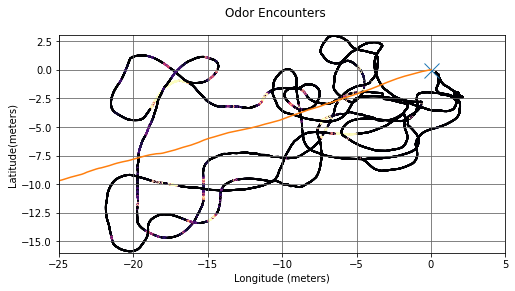

In [11]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor Encounters')

# Plot the data
ax.scatter(geodf.xsrc, geodf.ysrc, c=geodf.odor, cmap='magma', s= 0.8)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0)
ax.set_xlim(-25,5)
ax.set_ylim(-16,3)

#### 2D scatter plot for high odor concentration vs ideal wind particle

(-16.0, 3.0)

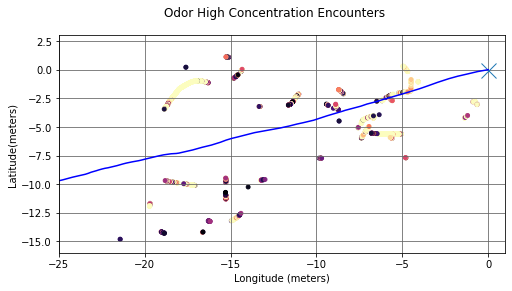

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor High Concentration Encounters')

# Plot the data
ax.scatter(df_t.xsrc, df_t.ysrc, c=df_t.odor, cmap='magma', s= 15)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, markersize=20, c='b')
ax.set_xlim(-25,1)
ax.set_ylim(-16,3)

#### ANIMATION 02 - Ideal vs Encountered Odor

In [17]:
## Setting figure

fig = plt.figure()
ax = plt.axes(xlim=(-25,2.5), ylim=(-16,3))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()

wind, = ax.plot([],[], 'o', color ="b", lw = 2)
line, = ax.plot([],[], 'x', color = "r", lw = 2)

def init():
    line.set_data([],[])  
    wind.set_data([],[])
    return wind,

def get_data_we_(i):
    return dfwe.loc[i]

def get_data_ns_(i):
    return dfns.loc[i]

def get_data_x_(i):
    return geodfsub.xsrc[i]

def get_data_y_(i):
    return geodfsub.ysrc[i]

def update(i):
    wex = get_data_we_(i)
    nsy = get_data_ns_(i)
    wind.set_data(wex,nsy)
#     x = get_data_x_(i)
#     y = get_data_y_(i)
#     line.set_data(x,y)
    
    return wind,



In [19]:
# ani = animation.FuncAnimation(fig, update, init_func=init, frames = int(len(geodfsub.ysrc)/2), interval = 5, blit=False)
ani = animation.FuncAnimation(fig, update, init_func=init, frames = 500, interval = 5, blit=False)


#ani.save('../../../Research/Images/Video/test_ideal.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
#HTML(ani.to_html5_video())




#### Note: Number of rows for wind sensor for a certain time slot is much lesser than number of rows of the data collected (position data) >>>> GPS frequency is much higher